In [1]:
from lofarantpos.db import LofarAntennaDatabase
import lofarantpos.geo as lofargeo
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.coordinates import ITRS, EarthLocation, GCRS, SkyCoord, AltAz
import numpy as np
from numpy.linalg import norm

In [2]:
db = LofarAntennaDatabase()

In [3]:
t0 = Time("2019-01-01T01:00")
stationname = "CS301LBA"

In [4]:
def station_to_itrs(station_name):
    """Returns an astropy ITRS coordinate for a given station (e.g. 'CS001LBA')"""
    x,y,z = db.phase_centres[station_name]
    return ITRS(x=x*u.m, y=y*u.m, z=z*u.m)

In [5]:
def station_to_earthlocation(station_name):
    """Returns an astropy EarthLocation for a given station (e.g. 'CS001LBA')"""
    x,y,z = db.phase_centres[station_name]
    return EarthLocation(x=x*u.m, y=y*u.m, z=z*u.m)

We will test at zenith:

In [6]:
test_coord_skycoord = AltAz(location=station_to_earthlocation(stationname),
                            alt=89.0*u.deg, az=0*u.deg,
                            obstime=t0).transform_to(GCRS)

In [7]:
test_coord_gcrs = test_coord_skycoord.cartesian.get_xyz().value

Let's make a matrix to go from sky (GCRS) to ITRS:

In [8]:
def gcrs_to_itrs(t):
    return SkyCoord(x=np.array([1,0,0]),
                    y=np.array([0,1,0]),
                    z=np.array([0,0,1]),
                    representation_type='cartesian'
                   ).transform_to(ITRS(obstime=t)).cartesian.get_xyz().value

In [9]:
gcrs_to_itrs(t0)

array([[-4.25129940e-01,  9.05181167e-01,  8.24577429e-04],
       [-9.05130523e-01, -4.25025946e-01,  1.72871689e-03],
       [ 1.80872021e-03, -3.48446758e-05,  9.99998166e-01]])

Test that this matrix does the same thing as an astropy transformation:

In [10]:
m31 = SkyCoord.from_name("M31")

In [11]:
gcrs_to_itrs(t0).dot(m31.cartesian.get_xyz().value)

array([-0.18731299, -0.72661166,  0.66092166])

In [12]:
m31.transform_to(ITRS(obstime=t0))

<SkyCoord (ITRS: obstime=2019-01-01T01:00:00.000): (x, y, z) [dimensionless]
    (-0.18731371, -0.72665471, 0.66097391)>

Yay.

To test whether we computed zenith, let's test whether the ITRS-vector of zenith corresponds to the ITRS-vector that points towards the station phase center.

In [13]:
station_itrs = station_to_itrs('CS301LBA').cartesian.get_xyz().value
station_itrs /= norm(station_itrs)

In [14]:
np.rad2deg(np.arccos((gcrs_to_itrs(t0)@test_coord_gcrs)@station_itrs))

1.0797122426452053

Ok, somehow there is an error of about one degree. That's probably because the station plane is not exactly tangent to a spherical earth. Let's ignore for now.

Define the dipoles, as unit vectors in the PQR system, and convert them to ETRS.

In [15]:
pqr_to_etrs = db.pqr_to_etrs[stationname]

In [16]:
a = np.sqrt(.5)
dipoles_pqr = np.array([[ a,  a, 0],
                        [ a, -a, 0],
                        [-a, -a, 0],
                        [-a,  a, 0]]).T

Note that we assume here that ITRS = ETRS, which is true to the meter level. (We could use Michiel's `etrsitrs` package here, but I think we've already got enough coordinate frames.)

So, now we have three coordinate frames:
 * GCRS (sky)
 * ITRS (Earth)
 * pqr (station)
 
We have two matrices to convert between these:
 * `pqr_to_etrs`
 * `gcrs_to_itrs`

To convert the other way around, these matrices need to be inverted, which is the same as transposing them because they are orthonormal.

In [17]:
pqr_to_etrs@(pqr_to_etrs.T)

array([[ 1.00000000e+00, -4.05491097e-11, -3.04055904e-11],
       [-4.05491097e-11,  1.00000000e+00, -9.99179732e-12],
       [-3.04055904e-11, -9.99179732e-12,  1.00000000e+00]])

We can get rid of the ITRS frame by creating a pqr_to_gcrs.

In [18]:
def gcrs_to_pqr(t):
    return gcrs_to_itrs(t)@(pqr_to_etrs.T)

In [20]:
test_coord_gcrs

array([-0.31094028,  0.49943389,  0.80862966])

Project the dipoles to the plane orthogonal to the test_coord. Do this in ITRS frame.

In [21]:
test_coord_itrs = gcrs_to_itrs(t0)@test_coord_gcrs

In [22]:
dipoles_itrs = pqr_to_etrs@dipoles_pqr

In [23]:
dipoles_projected_itrs = dipoles_itrs - \
                         test_coord_itrs.dot(dipoles_itrs) * test_coord_itrs[:, np.newaxis]

Check that the projected dipoles are indeed orthogonal to the test coordinate:

In [24]:
dipoles_projected_itrs.T@test_coord_itrs

array([-8.74538288e-07,  8.61327524e-07,  8.74538288e-07, -8.61327524e-07])

Yay.

In [132]:
dipoles_projected_gcrs = (gcrs_to_itrs(t0).T)@dipoles_projected_itrs

These are the dipoles projected to GCRS. All we need to do now is plot them on the plane orthogonal to the vector `test_coord_gcrs`.
Unfortunately I don't know how to do this properly. Idea for now: rotate along the *z*-axis to set RA to zero, then rotate along the `y`-axis to set DEC to zero. Then the vectors should point straight up.

In [80]:
def rot_ra(phi):
    """Rotates back along the z-axis with an angle phi"""
    return  np.array([[np.cos(-phi), - np.sin(-phi), 0],
                      [np.sin(-phi),   np.cos(-phi), 0],
                      [0, 0, 1]])

Let's check this matrix by rotating `test_coord` back to ra=0:

In [81]:
test_coord_gcrs_rotra = rot_ra(test_coord_skycoord.ra)@test_coord_gcrs

In [82]:
test_coord_skycoord_rotra = SkyCoord(x=test_coord_gcrs_rotra[0],
                                     y=test_coord_gcrs_rotra[1],
                                     z=test_coord_gcrs_rotra[2],
                                     representation_type='cartesian',frame=GCRS).transform_to(GCRS)

In [95]:
test_coord_skycoord.ra.degree

121.90579251208747

In [93]:
test_coord_skycoord_rotra.ra.degree

359.99999999999324

Yay. Check that the declination does not change:

In [94]:
test_coord_skycoord.dec.degree

53.96226118375554

In [92]:
test_coord_skycoord_rotra.dec.degree

53.96226118377357

Yay.

Now rotate the declination.

In [110]:
def rot_dec(theta):
    """Rotates back along the y-axis with an angle theta"""
    return  np.array([[np.cos(-theta), 0, - np.sin(-theta)],
                      [0,              1,                0],
                      [np.sin(-theta), 0,   np.cos(-theta)]])

Test that this works:

In [116]:
test_coord_gcrs_rotdec = rot_dec(test_coord_skycoord_rotra.dec)@test_coord_gcrs_rotra

In [117]:
test_coord_skycoord_rotdec = SkyCoord(x=test_coord_gcrs_rotdec[0],
                                      y=test_coord_gcrs_rotdec[1],
                                      z=test_coord_gcrs_rotdec[2],
                                      representation_type='cartesian',frame=GCRS).transform_to(GCRS)

In [118]:
test_coord_skycoord_rotdec.dec.degree

-2.2151557830572218e-11

In [119]:
test_coord_skycoord_rotra.ra.degree

359.99999999999324

In [120]:
test_coord_skycoord_rotdec.ra.degree

359.9999999999905

In [121]:
test_coord_skycoord_rotdec.ra

<Longitude 360. deg>

In [123]:
def rotate_back_gcrs(coord_skycoord):
    """Rotate back so that at coord_skycoord is at ra=0, dec=0"""
    return rot_dec(coord_skycoord.dec)@rot_ra(coord_skycoord.ra)

In [125]:
rotate_back_gcrs(test_coord_skycoord)@test_coord_gcrs

array([ 1.00000000e+00,  0.00000000e+00, -1.11022302e-16])

In [128]:
dipoles_projected_gcrs

array([[-0.29572218, -0.90317679,  0.29572218,  0.90317679],
       [-0.85933662,  0.10938401,  0.85933662, -0.10938401],
       [ 0.41703766, -0.41485401, -0.41703766,  0.41485401]])

In [130]:
rotate_back_gcrs(test_coord_skycoord)@dipoles_projected_gcrs

array([[-8.74538288e-07,  8.61327524e-07,  8.74538288e-07,
        -8.61327524e-07],
       [ 7.05224129e-01,  7.08911183e-01, -7.05224129e-01,
        -7.08911183e-01],
       [ 7.08865553e-01, -7.05153862e-01, -7.08865553e-01,
         7.05153862e-01]])

In [136]:
dipoles_gcrs = (gcrs_to_itrs(t0).T)@pqr_to_etrs@dipoles_pqr

In [139]:
dipoles_projected_rotated = rotate_back_gcrs(test_coord_skycoord)@dipoles_gcrs

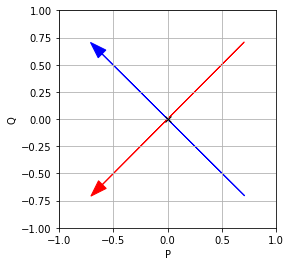

In [142]:
fig, ax = plt.subplots(1)
x, y = dipoles_projected_rotated[1:3]
ax.grid()
ax.arrow(x[0], y[0], x[2] - x[0], y[2] - y[0], head_width=0.1, color='r',
         length_includes_head=True)
ax.arrow(x[1], y[1], x[3] - x[1], y[3] - y[1], head_width=0.1, color='b',
         length_includes_head=True)
ax.set_aspect(1)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel("P")
ax.set_ylabel("Q")
ax.plot(0, 0, 'kx');

In [19]:
from ipywidgets import interact, interactive, fixed, interact_manual

In [20]:
def plot_wrap(t: float):
    return plot_rotation(t0 + t * u.day)

In [21]:
interactive_plot = interactive(plot_wrap, t=(0., 1., 0.05))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.05), Output(layout=Layout(height…